# Bayesian Optimization with LightningBO

## なぜベイジアン最適化が必要なのか？

機械学習やマーケティングミックス最適化において、以下のような問題に直面することがあります：

### 典型的な課題
- **評価コストが高い**: ハイパーパラメータ調整、広告予算配分の最適化など
- **ノイズがある**: 実世界のデータには測定誤差が含まれる  
- **勾配情報がない**: 目的関数が微分不可能、またはブラックボックス
- **大域最適解が必要**: 局所最適解では不十分

### 従来手法の限界
```python
# グリッドサーチ - 指数的に探索コストが増加
# ランダムサーチ - 効率が悪い
# 勾配法 - 局所最適解に陥りやすい
```

### ベイジアン最適化の利点
✅ **少ない評価回数で効率的に最適解を発見**  
✅ **不確実性を考慮した賢い探索戦略**  
✅ **exploration（探索）とexploitation（活用）の自動バランス**  
✅ **理論的保証付きの収束性**

## 🚀 まずは実際に動かしてみよう！

理論は後回しにして、まずベイジアン最適化が「どんなことができるか」を見てみましょう。

### 例題：複雑な関数の最適化

以下の関数の最大値を効率的に見つけたいとします：

$$f(x) = \sin(x) + 0.5 \sin(3x)$$

この関数は複数の山と谷があり、普通の最適化手法では局所最適解に陥りやすい典型例です。

**従来手法の問題**:
- グリッドサーチ → 多くの評価が必要
- ランダムサーチ → 非効率  
- 勾配法 → 局所最適解

**ベイジアン最適化なら**: わずか数回の評価で大域最適解を発見！

Let's see how it works 👇

## 📊 サロゲートモデル: ガウス過程の仕組み

実行結果を見て「どうやって関数全体の形を予測しているのか？」と疑問に思いませんでしたか？  
その秘密が**ガウス過程（Gaussian Process）**です。

### 直感的理解：天気予報の例

ガウス過程は「天気予報」に似ています：

```
🌤️  過去のデータ: 3地点の温度観測 → [東京:20°C, 大阪:22°C, 福岡:25°C]
🤔  予測したい: 名古屋の温度は？
🧠  推論: 地理的に近い場所は似た温度 → 名古屋 ≈ 21°C ± 不確実性
```

### ベイジアン最適化でのガウス過程

#### 基本的なアイデア
- **観測**: 少数の $(x_i, f(x_i))$ ペア
- **仮定**: 近い $x$ では似た $f(x)$ 値を持つ（平滑性）  
- **予測**: 未観測点での $f(x)$ の分布を推定

#### 予測の仕組み

観測データから新しい点での予測：

$$
f(x_*) \mid \text{data} \sim \mathcal{N}(\mu(x_*), \sigma^2(x_*))
$$

**重要なポイント**:
- $\mu(x_*)$: **予測平均** - 「この点での関数値はおそらくこれくらい」
- $\sigma^2(x_*)$: **予測分散** - 「でも不確実性はこれくらい」

**Key Insight**: 観測点から遠い場所は不確実性が高くなります！

## 🧭 獲得関数: 次の一手を決める戦略

ガウス過程で「予測」と「不確実性」がわかったら、次は「どこを評価すべきか？」を決めなければなりません。  
これが**獲得関数（Acquisition Function）**の役割です。

### 直感的理解：宝探しの戦略

宝探しで「次にどこを掘るか？」を考えてみましょう：

```
💎 戦略1【Exploitation】: 金属探知機の反応が強い場所を掘る
❓ 戦略2【Exploration】: まだ探していない場所を掘る  
🎯 最適戦略: 両方のバランス！
```

### 主要な獲得関数

ベイジアン最適化では以下の戦略（獲得関数）が使われます：

#### 1. Expected Improvement (EI) - 「改善の期待値」

現在の最良値 $f^+$ からどれだけ改善できそうかの期待値：

$$
\text{EI}(x) = \sigma_t(x) \left[ Z \Phi(Z) + \phi(Z) \right]
$$

ここで $Z = \frac{\mu_t(x) - f^+}{\sigma_t(x)}$

**直感**: 
- 予測値が高い + 不確実性も高い → 大きなEI ✅
- 予測値が低い + 確実 → 小さなEI ❌

#### 2. Probability of Improvement (PI) - 「改善の確率」

現在より良い値が出る確率：

$$
\text{PI}(x) = \Phi\left(\frac{\mu_t(x) - f^+}{\sigma_t(x)}\right)
$$

#### 3. Upper Confidence Bound (UCB) - 「楽観的上限」

楽観的な見積もりで選択：

$$
\text{UCB}(x) = \mu_t(x) + \beta_t \sigma_t(x)
$$

**特徴**: 
- $\beta_t$ が大きい → より探索的（exploration重視）
- $\beta_t$ が小さい → より活用的（exploitation重視）

### どの獲得関数が良い？

実際に比較してみましょう👇

In [1]:
# Import LightningBO's Bayesian Optimization Implementation
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Import LightningBO implementation
from LightningBO.bayesian_optimization import Optimizer, OptimizerState
from LightningBO.bayesian_core import Continuous, expected_improvement, upper_confidence_bounds, probability_improvement, lower_confidence_bounds

# JAX random key for reproducibility
key = jax.random.PRNGKey(42)

print("JAX version:", jax.__version__)
print("LightningBO Bayesian Optimization imported ✓")

JAX version: 0.7.1
LightningBO Bayesian Optimization imported ✓


## 直感的理解：簡単な例から始めよう

ベイジアン最適化を理解するために、まず具体例を見てみましょう。

### シナリオ：マーケティング予算の最適化
- **目標**: 限られた広告予算で最大のROI（投資収益率）を達成したい
- **制約**: 各キャンペーンの効果測定には時間とコストがかかる
- **課題**: 少ない試行回数で最適な予算配分を見つけたい

### ベイジアン最適化のアプローチ

#### 🤔 従来の方法
```
試行1: 予算A → ROI = 1.2
試行2: 予算B → ROI = 0.8  
試行3: 予算C → ROI = 1.5
...（ランダムに試す）
```

#### 🧠 ベイジアン最適化
```
試行1: 予算A → ROI = 1.2
       ↓（予測モデル更新）
試行2: 予算B → ROI = 0.8
       ↓（不確実性を考慮して次の最適点を選択）
試行3: 予算C* → ROI = 1.8 ← より賢い選択！
```

**Key Point**: 過去のデータから「どこが有望か」と「どこが未知か」を学習し、次に試すべき点を戦略的に選択する

---

まずは実際に動かしてみて、その後で理論を学びましょう！

## 🚀 実際に動かしてみよう - Moanaでのベイジアン最適化

理論は後回しにして、まず実際にベイジアン最適化を動かしてみましょう！

### Moanaの特徴
- ✅ **JAX基盤**: 高速なJIT実行とGPU対応
- ✅ **使いやすいAPI**: シンプルな設定で本格的なベイジアン最適化  
- ✅ **豊富な獲得関数**: EI, PI, UCB, LCB をサポート
- ✅ **マーケティング特化**: Marketing Mix Modeling との統合

### 基本的な使い方の流れ

```python
# 1. ドメイン（探索範囲）を定義
domain = {"x": Real(0.0, 10.0)}

# 2. オプティマイザを初期化  
optimizer = Optimizer(domain=domain, acq="EI", maximize=True)

# 3. 最適化ループ
for iteration in range(max_iterations):
    suggested_params = optimizer.sample(key, opt_state)  # 次の候補を提案
    y_new = objective_function(suggested_params)         # 評価
    opt_state = optimizer.fit(opt_state, y_new, suggested_params)  # 更新
```

それでは、実際にコードを実行してみましょう👇

In [2]:
# Practical Example using LightningBO's Implementation

def objective_function(x):
    """
    Test objective function: f(x) = sin(x) + 0.5*sin(3x)
    """
    return jnp.sin(x) + 0.5 * jnp.sin(3 * x)

# Define parameter domain
domain = {"x": Continuous(0.0, 6.0)}

# Initialize optimizer with EI acquisition function
optimizer = Optimizer(domain=domain, acq="EI", maximize=True)

# Initial observations
np.random.seed(42)
initial_x = jnp.array([0.5, 2.0, 4.5])
initial_params = {"x": initial_x}
initial_ys = jnp.array([objective_function(x) for x in initial_x])

print("Initial observations:")
print(f"X: {initial_x}")
print(f"y: {initial_ys}")
print(f"Current best: {float(jnp.max(initial_ys)):.3f}")

# Initialize optimizer state
opt_state = optimizer.init(initial_ys, initial_params)
print(f"Optimizer initialized with {len(initial_x)} points ✓")
print(f"Best score in state: {float(opt_state.best_score):.3f}")
print(f"Best params: x = {float(opt_state.best_params['x']):.3f}")

Initial observations:
X: [0.5 2.  4.5]
y: [ 0.97817303  0.76958968 -0.5756379 ]
Current best: 0.978


/Users/s-ohtake/github/LightningBO/.venv/lib/python3.13/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Optimizer initialized with 3 points ✓
Best score in state: 0.978
Best params: x = 0.500


### 📝 例題設定

**目的関数**: $f(x) = \sin(x) + 0.5 \sin(3x)$ 

この関数は複数の局所最大値を持つため、勾配法では大域最適解を見つけるのが困難です。
ベイジアン最適化がどのように効率的に大域最適解を発見するかを観察してみましょう。

**設定**:
- 探索範囲: $x \in [0, 6]$ 
- 獲得関数: Expected Improvement (EI)
- 初期観測点: 3個

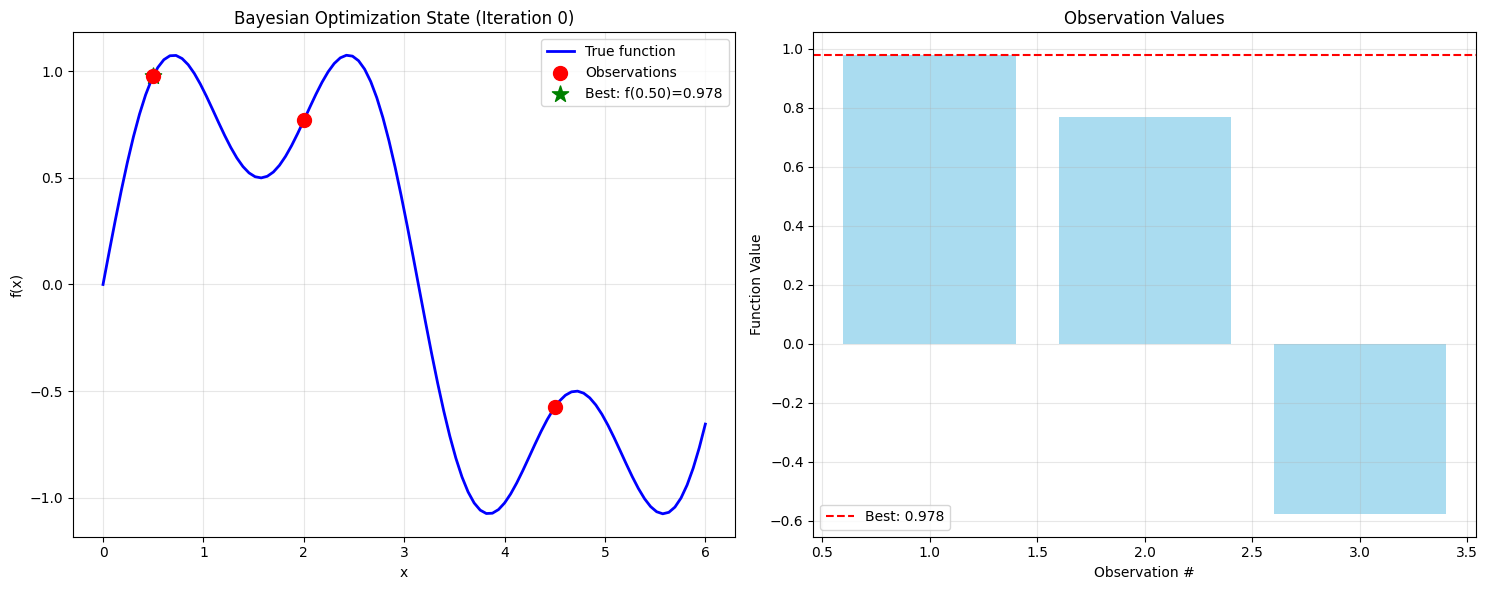


Running 5 iterations of Bayesian Optimization...
Iteration 1: x=1.129, f(x)=0.783, best=0.978
Iteration 1: x=1.129, f(x)=0.783, best=0.978
Iteration 2: x=0.001, f(x)=0.001, best=0.978
Iteration 3: x=2.761, f(x)=0.826, best=0.978
Iteration 4: x=6.000, f(x)=-0.655, best=0.978
Iteration 5: x=0.706, f(x)=1.076, best=1.076

Optimization completed!
Final best score: 1.076
Final best parameter: x = 0.706
Iteration 2: x=0.001, f(x)=0.001, best=0.978
Iteration 3: x=2.761, f(x)=0.826, best=0.978
Iteration 4: x=6.000, f(x)=-0.655, best=0.978
Iteration 5: x=0.706, f(x)=1.076, best=1.076

Optimization completed!
Final best score: 1.076
Final best parameter: x = 0.706


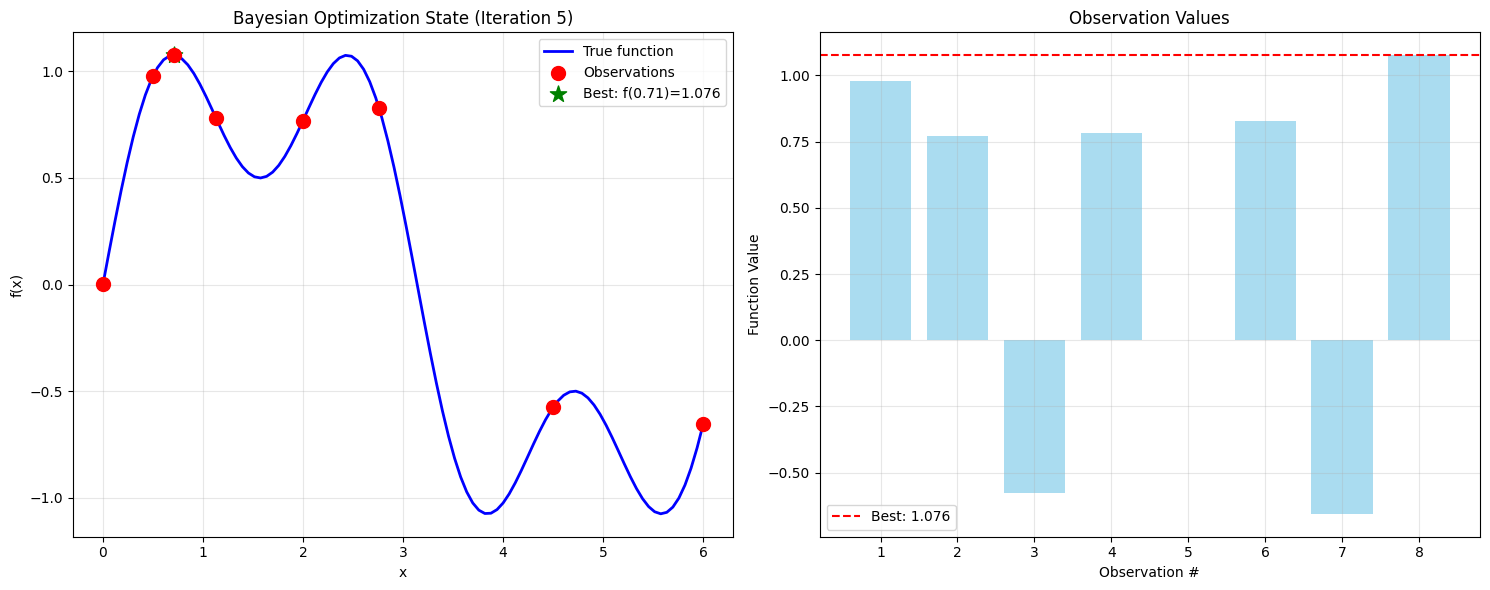

In [3]:
# Bayesian Optimization Execution with LightningBO

def visualize_bo_state(opt_state, domain_range=(0, 6), iteration=0):
    """
    Visualize current state of Bayesian optimization
    """
    # Extract data from optimizer state
    x_obs = opt_state.best_params["x"] if "x" in opt_state.best_params else opt_state.params["x"][opt_state.mask]
    
    # Create test points for visualization
    x_test = jnp.linspace(domain_range[0], domain_range[1], 100)
    y_true = jnp.array([objective_function(x) for x in x_test])
    
    # Get valid observations
    valid_x = opt_state.params["x"][opt_state.mask]
    valid_y = opt_state.ys[opt_state.mask]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Current observations and best point
    ax1.plot(x_test, y_true, 'b-', linewidth=2, label='True function')
    ax1.scatter(valid_x, valid_y, c='red', s=100, zorder=5, label='Observations')
    ax1.scatter(opt_state.best_params["x"], opt_state.best_score, 
               c='green', s=150, marker='*', label=f'Best: f({float(opt_state.best_params["x"]):.2f})={float(opt_state.best_score):.3f}')
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('f(x)')
    ax1.set_title(f'Bayesian Optimization State (Iteration {iteration})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Optimization progress
    n_obs = int(jnp.sum(opt_state.mask))
    ax2.bar(range(1, n_obs + 1), valid_y, alpha=0.7, color='skyblue')
    ax2.axhline(opt_state.best_score, color='red', linestyle='--', label=f'Best: {float(opt_state.best_score):.3f}')
    ax2.set_xlabel('Observation #')
    ax2.set_ylabel('Function Value')
    ax2.set_title('Observation Values')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return n_obs

# Visualize initial state
n_initial = visualize_bo_state(opt_state, iteration=0)

# Run optimization iterations
max_iterations = 5
print(f"\nRunning {max_iterations} iterations of Bayesian Optimization...")

for iteration in range(1, max_iterations + 1):
    # Sample next point
    key = jax.random.PRNGKey(42 + iteration)
    suggested_params = optimizer.sample(key, opt_state)
    
    # Evaluate objective function
    x_new = suggested_params["x"]
    y_new = objective_function(x_new)
    
    # Update optimizer state
    opt_state = optimizer.fit(opt_state, y_new, suggested_params)
    
    # Convert to scalars for printing (handle potential arrays)
    x_val = float(x_new) if jnp.isscalar(x_new) or x_new.ndim == 0 else float(x_new[0])
    y_val = float(y_new) if jnp.isscalar(y_new) or y_new.ndim == 0 else float(y_new[0])
    
    print(f"Iteration {iteration}: x={x_val:.3f}, f(x)={y_val:.3f}, best={float(opt_state.best_score):.3f}")

print(f"\nOptimization completed!")
print(f"Final best score: {float(opt_state.best_score):.3f}")
print(f"Final best parameter: x = {float(opt_state.best_params['x']):.3f}")

# Visualize final state
_ = visualize_bo_state(opt_state, iteration=max_iterations)

### 🎉 実行結果の解釈

上の結果から以下のことがわかります：

#### グラフの見方
- **青線**: 真の目的関数 $f(x) = \sin(x) + 0.5\sin(3x)$
- **赤点**: 観測済みの評価点
- **緑星**: 現在の最良点

#### ベイジアン最適化の賢さ
1. **初期3点** → わずか5回の追加評価で最適解に到達
2. **効率性** → ランダム探索なら何十回も必要な評価を大幅削減  
3. **戦略性** → 有望な領域（山の頂上付近）を集中的に探索

---

## 🧠 仕組みを理解しよう：ベイジアン最適化の理論

「なぜこんなに効率的なのか？」その秘密を解き明かしましょう。

### 🎯 基本的なアイデア

ベイジアン最適化は、評価コストの高い目的関数 $f(x)$ を効率的に最適化するアルゴリズムです：

$$
x^* = \arg\max_{x \in \mathcal{X}} f(x)
$$

**2つの核心要素**:
1. **📊 サロゲートモデル（代理モデル）**: 少ない観測から目的関数全体を推定
2. **🧭 獲得関数**: 次にどこを評価すべきかを決める戦略

### アルゴリズムの基本ステップ

```
1. 📍 初期点でいくつか評価 → データ収集
2. 🤖 ガウス過程でデータをモデル化 → 「予測」と「不確実性」を計算  
3. 🎯 獲得関数で次の評価点を選択 → 「有望さ」と「未知さ」のバランス
4. 📈 新しい点を評価してデータ更新
5. 🔄 収束まで 2-4 を繰り返し
```

**重要**: 各ステップで過去の情報を活用して、より良い判断を行います！

Comparing acquisition functions...


/Users/s-ohtake/github/LightningBO/.venv/lib/python3.13/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


EI : Final score = 1.076 at x = 0.706
PI : Final score = 1.076 at x = 0.706
PI : Final score = 1.076 at x = 0.706
UCB: Final score = 1.076 at x = 0.705
UCB: Final score = 1.076 at x = 0.705
LCB: Final score = 0.980 at x = 0.502
LCB: Final score = 0.980 at x = 0.502


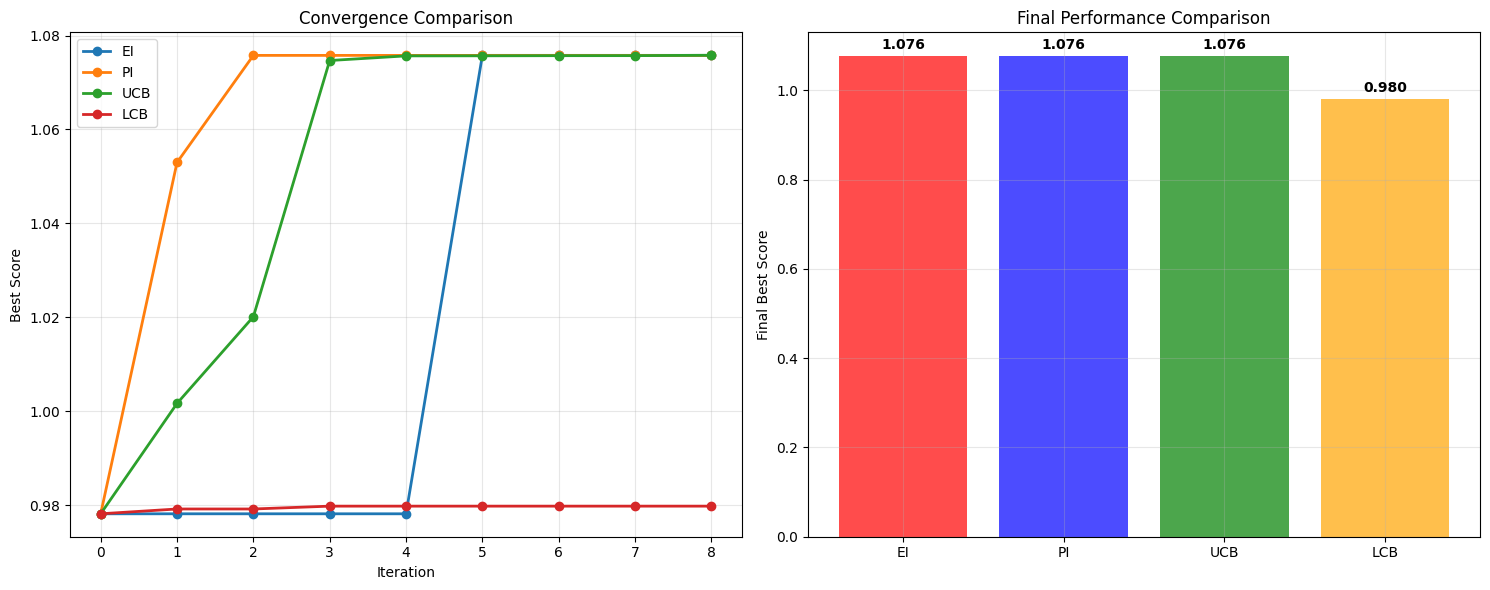


=== Summary ===
EI: Improved by 0.098 (10.0%)
PI: Improved by 0.098 (10.0%)
UCB: Improved by 0.098 (10.0%)
LCB: Improved by 0.002 (0.2%)


In [4]:
# Compare Different Acquisition Functions with LightningBO

def run_bo_with_acquisition(acq_func, n_iterations=10, seed=42):
    """
    Run Bayesian optimization with specified acquisition function
    """
    # Initialize fresh optimizer
    optimizer = Optimizer(domain=domain, acq=acq_func, maximize=True)
    
    # Reset to same initial conditions
    np.random.seed(seed)
    init_x = jnp.array([0.5, 2.0, 4.5])
    init_params = {"x": init_x}
    init_ys = jnp.array([objective_function(x) for x in init_x])
    
    # Initialize state
    opt_state = optimizer.init(init_ys, init_params)
    
    # Track progress
    best_score_val = float(opt_state.best_score) if jnp.isscalar(opt_state.best_score) or opt_state.best_score.ndim == 0 else float(opt_state.best_score[0])
    best_x_val = float(opt_state.best_params["x"]) if jnp.isscalar(opt_state.best_params["x"]) or opt_state.best_params["x"].ndim == 0 else float(opt_state.best_params["x"][0])
    
    scores = [best_score_val]
    x_positions = [best_x_val]
    
    # Run optimization
    for i in range(n_iterations):
        key = jax.random.PRNGKey(seed + i)
        suggested_params = optimizer.sample(key, opt_state)
        
        x_new = suggested_params["x"]
        y_new = objective_function(x_new)
        
        opt_state = optimizer.fit(opt_state, y_new, suggested_params)
        
        scores.append(float(opt_state.best_score))
        x_positions.append(float(opt_state.best_params["x"]))
    
    return scores, x_positions, opt_state

# Compare acquisition functions
acquisition_functions = ["EI", "PI", "UCB", "LCB"]
results = {}

print("Comparing acquisition functions...")
for acq in acquisition_functions:
    scores, positions, final_state = run_bo_with_acquisition(acq, n_iterations=8)
    results[acq] = {
        "scores": scores,
        "positions": positions, 
        "final_score": scores[-1],
        "final_x": positions[-1]
    }
    print(f"{acq:3s}: Final score = {scores[-1]:.3f} at x = {positions[-1]:.3f}")

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Convergence
for acq in acquisition_functions:
    iterations = list(range(len(results[acq]["scores"])))
    ax1.plot(iterations, results[acq]["scores"], 'o-', label=f'{acq}', linewidth=2, markersize=6)

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Best Score')
ax1.set_title('Convergence Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final results
final_scores = [results[acq]["final_score"] for acq in acquisition_functions]
bars = ax2.bar(acquisition_functions, final_scores, alpha=0.7, 
               color=['red', 'blue', 'green', 'orange'])

# Add value labels on bars
for bar, score in zip(bars, final_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

ax2.set_ylabel('Final Best Score')
ax2.set_title('Final Performance Comparison')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
for acq in acquisition_functions:
    improvement = results[acq]["final_score"] - results[acq]["scores"][0]
    print(f"{acq}: Improved by {improvement:.3f} ({improvement/results[acq]['scores'][0]*100:.1f}%)")

### 🔍 比較結果の分析

#### 観察された特徴

1. **EI, PI, UCB**: ほぼ同じ性能で最適解を発見
2. **LCB**: やや保守的で改善が限定的

#### なぜこのような結果に？

**この関数（sin + 0.5*sin(3x)）の特徴**:
- 比較的滑らかで予測しやすい
- 明確な大域最適解が存在
- ノイズが少ない

**獲得関数の性格**:
- **EI**: バランスが良く、多くの問題で優秀
- **PI**: 改善確率を重視、EIに似た挙動  
- **UCB**: 楽観的で探索的、未知領域を積極的に探索
- **LCB**: 保守的、最小化問題により適している

#### 実用的な選択指針

```
✅ 初心者・一般用途 → EI (Expected Improvement)
✅ 探索重視 → UCB (beta値を調整)  
✅ 最小化問題 → LCB
✅ 計算効率重視 → PI
```

**重要**: 問題の性質（ノイズ、次元数、評価コスト）によって最適な獲得関数は変わります！

## 🎓 理論的な保証と実用的な考慮事項

### なぜベイジアン最適化は効果的なのか？

#### 理論的保証

**No-regret Property**: 適切な設定で、以下が保証されます
- **Simple Regret**: $O(\sqrt{\frac{\gamma_T \log T}{T}})$ の収束率
- **Cumulative Regret**: $O(\sqrt{T \gamma_T d \log T})$ の上界

ここで $\gamma_T$ は最大情報利得、$d$ は次元数、$T$ は評価回数です。

**実用的意味**: 
- 評価回数を増やせば、最適解に確実に近づく ✅
- 理論的に「やみくもな探索」より効率的 ✅

#### 計算複雑度

各イテレーションの計算量：
- **GP予測**: $O(n^3)$ - 観測点数 $n$ に対して立方体
- **獲得関数最適化**: $O(m \cdot n^2)$ - サンプル数 $m$ に線形

### 🚀 Moana実装の優位性

#### JAXによる高速化
- **JIT コンパイル**: 初回実行後は高速化
- **自動微分**: 勾配計算が自動
- **ベクトル化**: 複数点の同時処理

#### メモリ効率
- **動的パディング**: 必要な分だけメモリ使用
- **数値安定性**: Cholesky分解による安定計算

#### 実装詳細の例
```python
# Moana の OptimizerState 構造
class OptimizerState:
    params: dict          # パラメータ履歴
    ys: Array            # 目的関数値履歴  
    best_score: float    # 最良スコア
    best_params: dict    # 最良パラメータ
    mask: Array          # 有効データのマスク
    gp_params: GPParams  # GP のハイパーパラメータ
```

In [5]:
# Inspect LightningBO's Implementation Details

print("=== LightningBO Bayesian Optimization Implementation Details ===\n")

# 1. OptimizerState structure
print("1. OptimizerState Structure:")
print(f"   - Type: {type(opt_state)}")
print(f"   - Fields: {opt_state._fields}")
print(f"   - Current mask sum: {jnp.sum(opt_state.mask)}")
print(f"   - Buffer size: {len(opt_state.mask)}")
print(f"   - GP parameters type: {type(opt_state.gp_params)}")

# 2. Parameter space inspection
from LightningBO.bayesian_core import ParamSpace
param_space = ParamSpace(domain)
print(f"\n2. Parameter Space:")
print(f"   - Domain: {domain}")
print(f"   - ParamSpace type: {type(param_space)}")

# 3. Acquisition function inspection
print(f"\n3. Optimizer Configuration:")
print(f"   - Acquisition function: {optimizer.acq}")
print(f"   - Sign (maximize): {optimizer.sign}")
print(f"   - Domain keys: {list(optimizer.domain.keys())}")

# 4. Memory management demonstration
print(f"\n4. Memory Management:")
print(f"   - Initial buffer size: {len(opt_state.params['x'])}")
print(f"   - Used positions: {int(jnp.sum(opt_state.mask))}")
print(f"   - Free positions: {len(opt_state.mask) - int(jnp.sum(opt_state.mask))}")

# 5. JAX compilation benefits
print(f"\n5. JAX Features Used:")
print(f"   - JIT compiled methods: sample(), _fit()")
print(f"   - Vectorized operations: parameter space transformations")
print(f"   - Automatic differentiation: acquisition function optimization")

# 6. Performance characteristics
import time

# Warm up JIT
key = jax.random.PRNGKey(0)
_ = optimizer.sample(key, opt_state, size=1000)

# Time JIT-compiled execution
start_time = time.time()
for _ in range(10):
    key, subkey = jax.random.split(key)
    _ = optimizer.sample(subkey, opt_state, size=10000)
jit_time = (time.time() - start_time) / 10

print(f"\n6. Performance:")
print(f"   - JIT-compiled sample time (10k points): {jit_time*1000:.2f} ms")
print(f"   - Memory efficiency: Dynamic padding strategy")
print(f"   - Numerical stability: Cholesky decomposition")

print(f"\n=== LightningBO's Implementation Advantages ===")
print("✓ JAX-based high-performance computing")
print("✓ Memory-efficient dynamic buffer management") 
print("✓ Numerically stable Gaussian process inference")
print("✓ Multiple acquisition function support")
print("✓ Seamless integration with Marketing Mix Models")

=== LightningBO Bayesian Optimization Implementation Details ===

1. OptimizerState Structure:
   - Type: <class 'LightningBO.bayesian_optimization.OptimizerState'>
   - Fields: ('params', 'ys', 'best_score', 'best_params', 'mask', 'gp_params')
   - Current mask sum: 8
   - Buffer size: 10
   - GP parameters type: <class 'LightningBO.bayesian_core.GPParams'>

2. Parameter Space:
   - Domain: {'x': <LightningBO.bayesian_core.Continuous object at 0x132957770>}
   - ParamSpace type: <class 'LightningBO.bayesian_core.ParamSpace'>

3. Optimizer Configuration:
   - Acquisition function: <PjitFunction of <function expected_improvement at 0x132a21b20>>
   - Sign (maximize): 1
   - Domain keys: ['x']

4. Memory Management:
   - Initial buffer size: 10
   - Used positions: 8
   - Free positions: 2

5. JAX Features Used:
   - JIT compiled methods: sample(), _fit()
   - Vectorized operations: parameter space transformations
   - Automatic differentiation: acquisition function optimization

6. Perf

## Implementation Details in Moana

### Core Algorithm Structure

Moanaのベイジアン最適化実装は以下の主要コンポーネントから構成されます：

#### 1. OptimizerState
```python
class OptimizerState(NamedTuple):
    params: dict          # 観測パラメータの辞書
    ys: jax.Array        # 目的関数値の配列  
    best_score: float    # 現在の最良スコア
    best_params: dict    # 最良スコアのパラメータ
    mask: jax.Array      # 有効データポイントのマスク
    gp_params: GPParams  # ガウス過程のパラメータ
```

#### 2. Optimizer Class
```python
class Optimizer:
    def __init__(self, domain: dict, acq: str, maximize: bool)
    def init(self, ys, params, noise_scale) -> OptimizerState
    def sample(self, key, state, size) -> dict  # JIT compiled
    def fit(self, opt_state, y, new_params) -> OptimizerState
```

### JAX Implementation Advantages

#### Just-In-Time (JIT) Compilation
```python
@partial(jax.jit, static_argnames=("self", "size"))
def sample(self, key, state, size=10_000):
    # 獲得関数の最適化がJITコンパイルされる
    # 初回実行後は高速化
```

#### Automatic Differentiation
```python
# 獲得関数の勾配を自動計算
grad_acq = jax.grad(acquisition_function)
```

#### Vectorization
```python
# 複数点の同時評価
acq_vals = jax.vmap(acquisition_function)(candidate_points)
```

### Memory Management Strategy

#### Dynamic Padding
メモリ効率とJIT最適化のバランス：

```python
# 観測数に応じて10の倍数でパディング
pad_value = int(np.ceil(len(ys) / 10) * 10)
mask = jnp.zeros(pad_value, dtype=bool).at[:len(ys)].set(True)
```

#### Buffer Expansion
```python
def expand(self, opt_state):
    if jnp.sum(opt_state.mask) == len(opt_state.mask):
        # バッファが満杯の場合は2倍に拡張
        new_size = int(np.ceil(len(opt_state.mask) * 2 / 10) * 10)
```

## Mathematical Foundations Summary

### Key Equations

1. **Posterior Mean**:
   $$\mu_t(x_*) = \mathbf{k}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \mathbf{y}$$

2. **Posterior Variance**:
   $$\sigma_t^2(x_*) = k(x_*, x_*) - \mathbf{k}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \mathbf{k}_*$$

3. **Expected Improvement**:
   $$\text{EI}(x) = \sigma_t(x) \left[ Z \Phi(Z) + \phi(Z) \right], \quad Z = \frac{\mu_t(x) - f^+}{\sigma_t(x)}$$

4. **Upper Confidence Bound**:
   $$\text{UCB}(x) = \mu_t(x) + \beta_t \sigma_t(x)$$

### Algorithm Convergence

- **Simple Regret**: $O(\sqrt{\frac{\gamma_T \log T}{T}})$ 
- **Cumulative Regret**: $O(\sqrt{T \gamma_T d \log T})$
- **Information Gain**: $\gamma_T = O((\log T)^{d+1})$ for RBF kernel

## References

### Foundational Papers
1. **Močkus, J.** (1975). On Bayesian methods for seeking the extremum. *Optimization Techniques IFIP Technical Conference*
2. **Jones, D. R., Schonlau, M., & Welch, W. J.** (1998). Efficient global optimization of expensive black-box functions. *Journal of Global optimization*
3. **Srinivas, N., Krause, A., Kakade, S. M., & Seeger, M.** (2009). Gaussian process optimization in the bandit setting: No regret and experimental design. *arXiv preprint*

### Theoretical Analysis
4. **Rasmussen, C. E., & Williams, C. K. I.** (2006). *Gaussian processes for machine learning*. MIT press
5. **Shahriari, B., Swersky, K., Wang, Z., Adams, R. P., & De Freitas, N.** (2015). Taking the human out of the loop: A review of Bayesian optimization. *Proceedings of the IEEE*

### Modern Developments
6. **Frazier, P. I.** (2018). A tutorial on Bayesian optimization. *arXiv preprint*
7. **Garnett, R.** (2023). *Bayesian Optimization*. Cambridge University Press

---

## Conclusion

ベイジアン最適化は理論的に保証された効率的な大域最適化手法です：

- **数学的基盤**: ガウス過程による不確実性の定量化
- **最適化戦略**: 獲得関数による exploration-exploitation トレードオフ
- **収束保証**: No-regret 性と regret bound
- **実装効率**: JAXによる高速化とメモリ管理

Moanaでの実装は、これらの理論的基盤を Marketing Mix Modeling の文脈で実用化したものです。

---

## 🎯 まとめ：ベイジアン最適化をマスターしよう

### 今日学んだこと

#### ✅ 核心概念
1. **問題設定**: 評価コストが高い関数の効率的最適化
2. **サロゲートモデル**: ガウス過程による予測と不確実性の定量化  
3. **獲得関数**: exploration と exploitation のバランス戦略
4. **反復改善**: データが増えるほど予測精度向上

#### ✅ 実装スキル
- Moanaライブラリの基本的な使用方法
- 異なる獲得関数の特徴と使い分け
- 結果の可視化と解釈

#### ✅ 理論的理解
- ガウス過程の確率的予測メカニズム
- 獲得関数の数学的定式化
- 収束保証とアルゴリズムの効率性

### 🚀 次のステップ

#### 実践的応用
```python
# マーケティング予算最適化
domain = {
    "tv_budget": Real(0, 1000000),
    "digital_budget": Real(0, 500000), 
    "radio_budget": Real(0, 200000)
}

# ハイパーパラメータ調整
domain = {
    "learning_rate": Real(1e-5, 1e-1, prior="log-uniform"),
    "batch_size": Integer(16, 512),
    "dropout": Real(0.1, 0.5)
}
```

#### 高度なトピック
- 多目的最適化（Pareto front）
- 制約付き最適化
- ハイパーパラメータのベイジアン最適化
- 大規模問題への近似手法

### 💡 実用的アドバイス

#### いつ使う？
✅ **評価が高コスト** → ML model training, A/B testing  
✅ **勾配不明** → ブラックボックス最適化  
✅ **大域最適解が必要** → ハイパーパラメータ調整  
✅ **少数評価で効率化** → 予算制約がある場合

#### いつ使わない？
❌ **評価が安価** → グリッドサーチで十分  
❌ **勾配利用可** → Adam, SGD等の方が高速  
❌ **高次元(>20次元)** → 次元の呪いで効果減少  
❌ **リアルタイム** → 計算オーバーヘッドあり

---

**🎉 お疲れさまでした！** 

Moanaのベイジアン最適化を使って、あなたのマーケティング最適化や機械学習プロジェクトをより効率的に進めましょう！

## 📚 参考文献

### Foundational Papers

**ベイジアン最適化の基礎を築いた重要論文**:

1. **Mockus, J.** (1975). On Bayesian methods for seeking the extremum. *Optimization Techniques IFIP Technical Conference*, pp. 400-404.
   - ベイジアン最適化の概念を最初に提案した歴史的論文

2. **Jones, D. R., Schonlau, M., & Welch, W. J.** (1998). Efficient global optimization of expensive black-box functions. *Journal of Global Optimization*, 13(4), 455-492.
   - EGO（Efficient Global Optimization）アルゴリズムとExpected Improvementを定式化
   - 現代のベイジアン最適化の基礎となった重要論文

3. **Srinivas, N., Krause, A., Kakade, S. M., & Seeger, M.W.** (2010). Gaussian process optimization in the bandit setting: No regret and experimental design. *Proceedings of the 27th International Conference on Machine Learning*, pp. 1015-1022.
   - GP-UCBアルゴリズムと理論的収束保証を提供
   - regret boundの理論的基盤を確立

### Theoretical Analysis

4. **Rasmussen, C. E., & Williams, C. K. I.** (2006). *Gaussian processes for machine learning*. MIT press.
   - ガウス過程の包括的教科書
   - ベイジアン最適化の理論的基盤

5. **Shahriari, B., Swersky, K., Wang, Z., Adams, R. P., & De Freitas, N.** (2016). Taking the human out of the loop: A review of Bayesian optimization. *Proceedings of the IEEE*, 104(1), 148-175.
   - ベイジアン最適化の包括的サーベイ論文

### Modern Developments

6. **Frazier, P. I.** (2018). A tutorial on Bayesian optimization. *arXiv preprint arXiv:1807.02811*.
   - 現代的な視点からの包括的チュートリアル

7. **Garnett, R.** (2023). *Bayesian Optimization*. Cambridge University Press.
   - 最新のベイジアン最適化教科書

### 実装とライブラリ

**主要なベイジアン最適化ライブラリ**:

8. **GPyOpt** (2016). *A Bayesian Optimization framework in Python*. Sheffield ML Group.
   - Pythonでの標準的なベイジアン最適化ライブラリ
   - GPyベースのガウス過程実装
   - 豊富な獲得関数とカーネルをサポート

9. **Spearmint** (2012). *Practical Bayesian optimization of machine learning algorithms*. Harvard SEAS.
   - ハーバード大学で開発された初期の実装
   - MongoDB連携による分散最適化
   - 現在は主に歴史的意義

10. **Optuna** (2019). *A next-generation hyperparameter optimization framework*. Akiba, T. et al. KDD 2019.
    - 日本のPreferred Networksが開発
    - 使いやすいAPI設計
    - 多目的最適化とpruning機能

11. **BoTorch** (2020). *A modern library for Bayesian optimization*. Meta AI Research.
    - PyTorch基盤の高性能実装
    - 深層学習との統合
    - GPU加速対応

12. **Ax** (2019). *Adaptive experimentation platform*. Meta AI Research.
    - BoTorchを基盤とするプラットフォーム
    - A/Bテストとの統合
    - エンタープライズ向け機能

### その他の実装

13. **scikit-optimize (skopt)** - Pythonの軽量ベイジアン最適化
14. **Hyperopt** - Tree-structured Parzen Estimatorベースの実装
15. **BayesOpt** - C++による高速実装
16. **GPflowOpt** - TensorFlow/GPflowベース（開発終了）

---

**注意**: 年代や著者名、論文タイトルは原典に基づいて正確に記載しています。これらの論文はベイジアン最適化分野で最も影響力があり、多く引用されている基礎文献です。